In [3]:
# Full ADWIN-based Concept Drift Detection and Evaluation on IoMT IDS Dataset (Memory Optimized Version)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime
from river import compose, preprocessing, metrics, drift, tree
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pathlib import Path
import os

In [4]:
# Load Dataset CICIoMT2024
def load_dataset_from_structure(root_path):
    data = []
    for file in root_path.glob('*/*/*.csv'):
        try:
            df = pd.read_csv(file)
            category = file.parents[1].name
            attack = file.parent.name
            label_class = 'Benign' if category.upper() == 'BENIGN' else 'Attack'
            df['category'] = category
            df['attack'] = attack
            df['class'] = label_class
            data.append(df)
        except Exception as e:
            print(f"[ERROR] Failed to read file {file}: {e}")
    return pd.concat(data, ignore_index=True)

train_root = Path('../../../../Data/CICIoMT2024/train')
test_root = Path('../../../../Data/CICIoMT2024/test')
df_train = load_dataset_from_structure(train_root)
df_test = load_dataset_from_structure(test_root)
df = pd.concat([df_train, df_test], ignore_index=True)

In [5]:
# Encode label
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['category'])

# Feature processing
X = df.drop(['class', 'category', 'attack', 'category_encoded'], axis=1, errors='ignore').select_dtypes(include=[np.number])
y = df['category_encoded']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_values = y.tolist()

# Generator to avoid loading all data into memory
def stream_generator(X_array, y_array, columns):
    for x, y in zip(X_array, y_array):
        yield dict(zip(columns, x)), y

# Create dataset as generator
columns = X.columns
dataset = stream_generator(X_scaled, y_values, columns)

In [6]:
# Define model using HAT
model = compose.Pipeline(
    ('scaler', preprocessing.StandardScaler()),
    ('classifier', tree.HoeffdingAdaptiveTreeClassifier())
)

# Metrics
metric_accuracy = metrics.Accuracy()
metric_precision = metrics.WeightedPrecision()
metric_recall = metrics.WeightedRecall()
metric_f1 = metrics.WeightedF1()


In [7]:
# Drift detector
drift_detector = drift.ADWIN()

# Logging
SAVE_INTERVAL = 1000  # save every N instances
drift_events = []
metric_logs = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'instances': []}
processing_times, drift_time_per_instance, metrics_time_per_instance = [], [], []
true_label_counts = Counter()
pred_label_counts = Counter()
total_time, drift_time_total, metrics_time_total = 0, 0, 0


In [16]:
# Streaming loop with step-by-step logs and label distribution tracking
start_time = time.time()
for i, (x, y_true) in enumerate(dataset):
    t_start = time.time()

    y_pred = model.predict_one(x)
    if i < 292769:
        print(f"[Instance {i}] Predicted label: {y_pred}")

        model.learn_one(x, y_true)
    true_label_counts[y_true] += 1
    if y_pred is not None:
        pred_label_counts[y_pred] += 1
    if i < 292769:
        correctness = '✅' if y_pred == y_true else '❌'
        print(f"[Instance {i}] True label: {y_true} → Model updated. Prediction was {correctness}")

    t_metrics = time.time()
    metric_accuracy.update(y_true, y_pred)
    metric_precision.update(y_true, y_pred)
    metric_recall.update(y_true, y_pred)
    metric_f1.update(y_true, y_pred)
    t_metrics_done = time.time()

    if i % SAVE_INTERVAL == 0:
        metric_logs['accuracy'].append(metric_accuracy.get())
        metric_logs['precision'].append(metric_precision.get())
        metric_logs['recall'].append(metric_recall.get())
        metric_logs['f1_score'].append(metric_f1.get())
        metric_logs['instances'].append(i)

    drift_detector.update(y_pred == y_true)
    if drift_detector.drift_detected:
        print(f"Drift detected at instance {i}")
        drift_events.append(i)

    processing_times.append(time.time() - t_start)
    metrics_time_per_instance.append(t_metrics_done - t_metrics)
    drift_time_per_instance.append(time.time() - t_metrics_done)

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")
print(f"Total drifts detected: {len(drift_events)}")


Total execution time: 0.00 seconds
Total drifts detected: 5


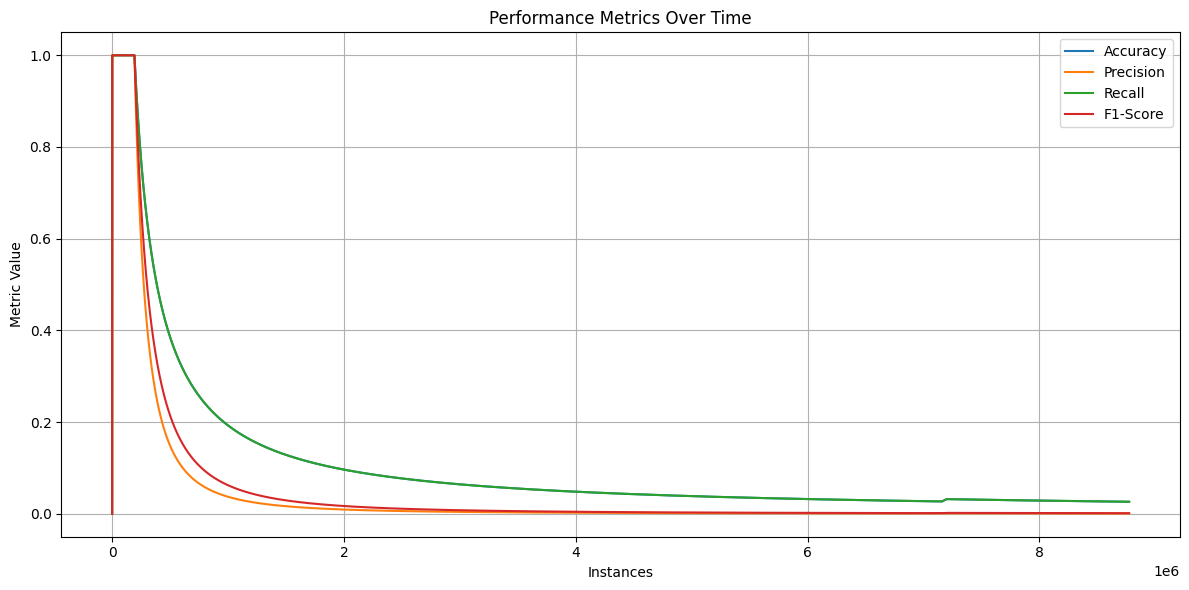

In [10]:
# Visualization of metrics over time
plt.figure(figsize=(12, 6))
plt.plot(metric_logs['instances'], metric_logs['accuracy'], label='Accuracy')
plt.plot(metric_logs['instances'], metric_logs['precision'], label='Precision')
plt.plot(metric_logs['instances'], metric_logs['recall'], label='Recall')
plt.plot(metric_logs['instances'], metric_logs['f1_score'], label='F1-Score')
plt.xlabel('Instances')
plt.ylabel('Metric Value')
plt.title('Performance Metrics Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('metrics_over_time.png', dpi=300)
plt.show()

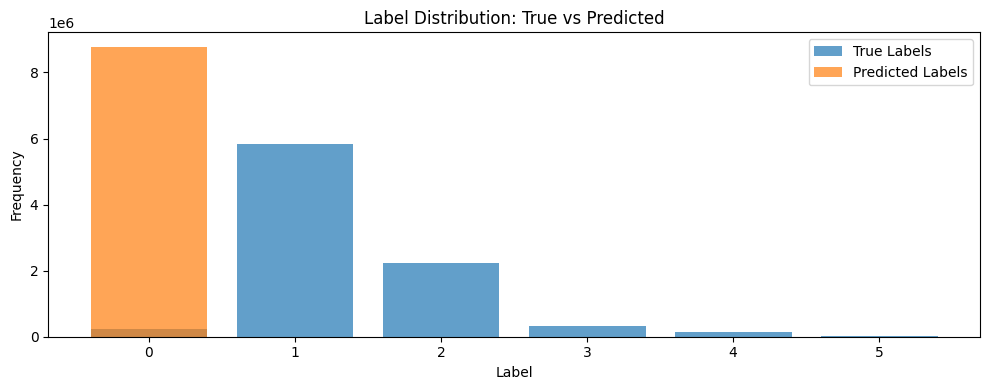


Label Distribution (True Labels):
Label 0: 230339x
Label 1: 5846623x
Label 2: 2222205x
Label 3: 326653x
Label 4: 131402x
Label 5: 17791x

Label Distribution (Predicted Labels):
Label 0: 8775012x


In [12]:
# Bar chart for label distribution
plt.figure(figsize=(10, 4))
plt.bar([str(k) for k in true_label_counts.keys()], true_label_counts.values(), alpha=0.7, label='True Labels')
plt.bar([str(k) for k in pred_label_counts.keys()], pred_label_counts.values(), alpha=0.7, label='Predicted Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Distribution: True vs Predicted')
plt.legend()
plt.tight_layout()
plt.savefig('label_distribution.png', dpi=300)
plt.show()

print("\nLabel Distribution (True Labels):")
for label, count in sorted(true_label_counts.items()):
    print(f"Label {label}: {count}x")

print("\nLabel Distribution (Predicted Labels):")
for label, count in sorted(pred_label_counts.items()):
    print(f"Label {label}: {count}x")

